# Experiment CRM Sim with SimPy

https://simpy.readthedocs.io/en/latest/contents.html

In [22]:
import pandas as pd
import random
import re
import simpy
import sys
import xml.etree.ElementTree as ET

from eccore.ipython import nb_setup
from pathlib import Path
from pprint import pprint
from uuid import uuid4

nb_setup()

from crm import CustomerRelationManagerSimulator
from enums import AccountStage, AccountStatus, AccountType, LeadSource, Month, OpportunityStage
from sdmodel import SDModel, stocks, var_of_interest, flows
from utils import dict_index, draw_value_beta

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode


1. **Prospecting**:  Identifying potential customers. -> MQL
2. **Qualification**:  Assessing fit and buying intent. -> SQL
3. **Needs Assessment**:  Understanding specific requirements. -> CONTACTED
4. **Presentation**:  Demonstrating the solution's value. -> PITCHED
5. **Proposal**:  Bid and Addressing concerns. -> BIDDED
6. **Closing**:  Securing commitment. -> SIGNED
7. **Post-Sale Follow-up**:  Ensuring satisfaction and fostering loyalty. -> goes back to SQL for other products

In [23]:
crm = CustomerRelationManagerSimulator(nb_accounts=100, nb_salesreps=2)
crm.retrieve_accounts()

,account_type,country,created,env,industry,lead_source,name,stage,uid,sales_rep
0,AccountType.SMALL,USA,0,<simpy.core.Environment object at 0x7f4d2216ba30>,Consumer Goods,LeadSource.WEBSITE_CTA,ValiantPac Solutions LLC,AccountStage.MQL,acct-0078b42b-832c-40f7-ba7d-c0d09e29d6b1,SalesRep(name=SalesRep 1 uid=srep-36275278-25a...
1,AccountType.SMALL,Germany,0,<simpy.core.Environment object at 0x7f4d2216ba30>,Pharmaceuticals,LeadSource.WEBSITE_CTA,CottbusFlex GmbH,AccountStage.MQL,acct-5115b367-0732-4c51-964e-2e817f53470e,SalesRep(name=SalesRep 1 uid=srep-36275278-25a...
2,AccountType.SMALL,USA,0,<simpy.core.Environment object at 0x7f4d2216ba30>,Electronics,LeadSource.WEBSITE_CTA,ApexWrap Inc.,AccountStage.MQL,acct-53fc07fd-ff91-49aa-b5e7-6c3701ec4579,SalesRep(name=SalesRep 1 uid=srep-36275278-25a...
3,AccountType.SMALL,China,0,<simpy.core.Environment object at 0x7f4d2216ba30>,Pharmaceuticals,LeadSource.WEBSITE_CTA,GanzhouFlex Ltd.,AccountStage.MQL,acct-03a847d6-7029-4aaf-b4a7-c594ab254558,SalesRep(name=SalesRep 1 uid=srep-36275278-25a...
4,AccountType.SMALL,Germany,0,<simpy.core.Environment object at 0x7f4d2216ba30>,Electronics,LeadSource.WEBSITE_CTA,BambergPack GmbH,AccountStage.MQL,acct-e2599040-5e7b-4a33-ab54-00ccb4b3c268,SalesRep(name=SalesRep 1 uid=srep-36275278-25a...
...,...,...,...,...,...,...,...,...,...,...
95,AccountType.SMALL,Italy,0,<simpy.core.Environment object at 0x7f4d2216ba30>,Food & Beverage,LeadSource.WEBSITE_CTA,RomeWrap S.p.A.,AccountStage.MQL,acct-7e0587b3-6fca-4296-8bc1-041b6353427f,SalesRep(name=SalesRep 2 uid=srep-668d8638-1a1...
96,AccountType.SMALL,Germany,0,<simpy.core.Environment object at 0x7f4d2216ba30>,Chemicals,LeadSource.WEBSITE_CTA,RavensburgPack GmbH,AccountStage.MQL,acct-63cc6a75-d4e3-44b7-a3d5-f8ddf020cce7,SalesRep(name=SalesRep 2 uid=srep-668d8638-1a1...
97,AccountType.SMALL,France,0,<simpy.core.Environment object at 0x7f4d2216ba30>,Industrial Manufacturing,LeadSource.WEBSITE_CTA,RennesFlex S.A.,AccountStage.MQL,acct-c5dfb946-852d-42da-8281-792e0d45a3a9,SalesRep(name=SalesRep 2 uid=srep-668d8638-1a1...
98,AccountType.SMALL,Canada,0,<simpy.core.Environment object at 0x7f4d2216ba30>,Pharmaceuticals,LeadSource.WEBSITE_CTA,HalifaxFlex Inc.,AccountStage.MQL,acct-f791d71f-c622-4f91-ba08-790908b54097,SalesRep(name=SalesRep 1 uid=srep-36275278-25a...


You can assign **realistic purchase orders** based on company size and industry:
- **SMALL**: $10,000 – $100,000 for SMEs
- **MEDIUM**: $100,000 – $500,000 for mid market companies
- **LARGE**: $500,000 – $2,000,000+ for large enterprises

Would you like sample purchase order entries for each country or by company size?

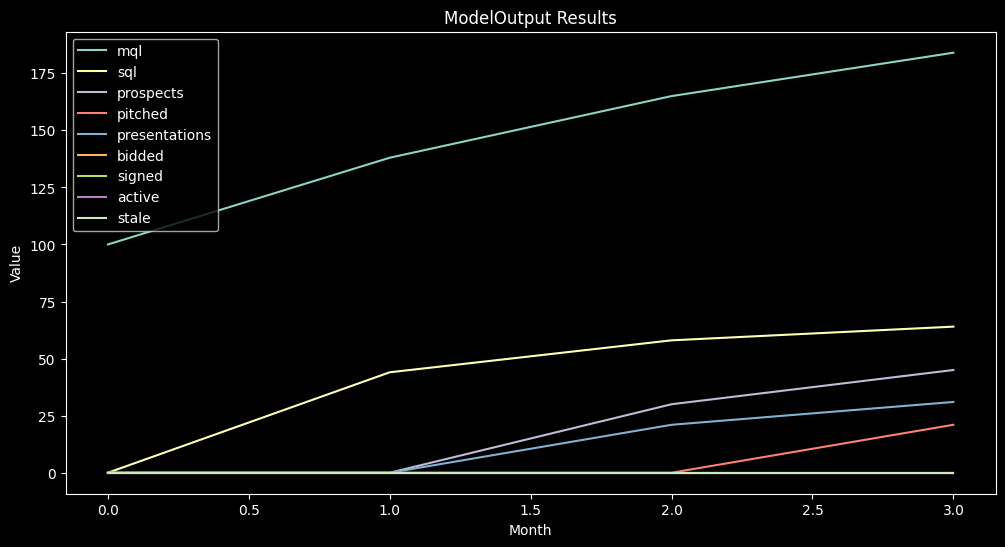

In [24]:
sim = SDModel()
sim.steps(num_steps=3)
sim.plot_results(coi=stocks)

In [25]:
display(sim.step_results_df.loc[:, flows['mql']].T)
# display(sim.step_results_df.loc[:, flows['mql']].T.sum(axis=1))

time,0,1,2,3
mql,100,138,165,184
mql website,35,35,35,35
mql online campaign,38,38,38,38
mql industry events,24,24,24,24
mql salesreps,0,0,0,0
sales qualified,44,50,54,57
mql decay,15,20,24,27


In [27]:
crm.update_accounts(sim.step_results_df)

## Sandbox

In [ ]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

# Parameters for the Beta distribution (right-skewed)
alpha = 2
beta_param = 5

# Number of samples to generate
n_samples = 10000

# Generate Beta distributed samples on [0, 1]
samples_unit = beta.rvs(alpha, beta_param, size=n_samples)

# Scale samples to [10000, 100000]
val_min, val_max = 10000, 100000
samples_scaled = val_min + samples_unit * (val_max - val_min)

# Optional: visualize the distribution
plt.hist(samples_scaled, bins=50, color='skyblue', edgecolor='black')
plt.title('Simulated Purchase Orders (Scaled Beta Distribution)')
plt.xlabel('Purchase Order Value')
plt.ylabel('Frequency')
plt.show()


XML Parsing

In [ ]:
import xml.etree.ElementTree as ET
p2xml = Path('../data/04-crm.xmile')
tree = ET.parse(p2xml)
root = tree.getroot()
# for child in root:
#     print(child.tag, child.attrib)

Get all variables name as per the model

In [ ]:
p2xml = Path('../data/04-crm.xmile')
tree = ET.parse(p2xml)
root = tree.getroot()

# Define the namespace (use the actual namespace in your XML)
ns = {'xmile': 'http://docs.oasis-open.org/xmile/ns/XMILE/v1.0'}

# Find all stock and aux elements
stocks = root.findall('.//xmile:stock', ns)
auxs = root.findall('.//xmile:aux', ns)

# Extract the 'name' attribute from each
stock_names = [stock.attrib['name'].replace('-', '_') for stock in stocks]
aux_names = [aux.attrib['name'].replace('-', '_') for aux in auxs]

print("Stock names:", stock_names)
print("Aux names:", aux_names)


In [ ]:
for s in stock_names:
    print(s)

In [ ]:
for a in aux_names:
    print(a)

In [ ]:
def get_aux_eqn(name, root, ns):

    aux_elem = root.find(f".//xmile:aux[@name='{name}']", ns)
    eqn_elem = aux_elem.find("xmile:eqn", ns)
    if eqn_elem is not None:
        eqn =  eqn_elem.text
    else:
        raise RuntimeError(f"No equation found for aux '{name}'")
    
    pat = re.compile(r'^(?:(?P<fctn>INTEGER\s*\()|())\s*(?P<eqn>.+?)\s*\)?\s*$')
    matches = pat.match(eqn)
    mdict = matches.groupdict()
    fctn = mdict.get('fctn',None)
    eqn = mdict.get('eqn',None)
    fcnt_start = '' if fctn is None else 'int('
    fctn_end = '' if fctn is None else ')'
    return f"{fcnt_start}{eqn}{fctn_end}"

aux_equations = {}
for aux_name in aux_names:
    aux_equations[aux_name] = get_aux_eqn(aux_name, root, ns)

# pprint(aux_equations)

In [ ]:
def get_stock_flows(name, root, ns):

    stock_elem = root.find(f".//xmile:stock[@name='{name}']", ns)
    inflow_elems = stock_elem.findall("xmile:inflow", ns)
    outflow_elems = stock_elem.findall("xmile:outflow", ns)
    if inflow_elems is not None:
        inflows =  [elem.text.replace('\n', '').replace('\t','').replace(' ','_') for elem in inflow_elems if elem.text is not None]
    else:
        raise RuntimeError(f"No inflow found for stock '{name}'")

    if outflow_elems is not None:
        outflows =  [elem.text.replace('\n', '').replace('\t','').replace(' ','_') for elem in outflow_elems if elem.text is not None]
    else:
        raise RuntimeError(f"No outflow found for stock '{name}'")

    return {'inflows': inflows, 'outflows': outflows}

stock_flows = {}
for name in stock_names:
    stock_flows[name] = get_stock_flows(name, root, ns)

# pprint(stock_flows)


<img src="/home/vtec/projects/diyai/crm-sim/img/mql.jpg" width="800">


### Extract aux variable from model

Get names of variables in the right order

In [ ]:
ordered_aux = [
    'decay_rate',
    'nb_mthly_website_visitor',
    'website_cta_rate',
    'raw_leads_from_website',
    'rawlead2mql_website',
    'mql_website',
    'online_campaigns_targets',
    'online_campaigns_clickthru',
    'rawleads_online_campaign',
    'rawlead2mql_online_campaign',
    'mql_online_campaign',
    'nb_industry_events',
    'rawleads_industry_events',
    'rawlead2mql_industry_event',
    'mql_industry_events',
    'rawleads_salesreps',
    'salesrep_leads2mql',
    'mql_salesreps',
    'new_mql',

    'mql2sql',
    'sql_salesreps',
    'sales_qualified',
    'mql_decay',

    'sql2prospect',
    'new_prospects',
    'sql_decay',

    'prospect2prez',
    'presentations',
    'prospect_decay',
    
    'prez2bid',
    'bids',
    'stale_prospects',

    'bid2close',
    'contracts',
    'lost_bids',

    'customer_satisfaction_rate',
    'satisfied',
    'unsatisfied',
    
    'completed',
]

In [ ]:
for aux_name in ordered_aux:
    print(f"{aux_name} = {aux_equations[aux_name]}")

In [ ]:
ordered_stock = [
    'mql',
    'sql',
    'prospects',
    'pitched',
    'bidded',
    'signed',
    'active',
    'stale',
]
for stock_name in ordered_stock:
    inflows = stock_flows[stock_name]['inflows']
    in_formula = ' + '.join(inflows) if inflows else '0'
    outflows = stock_flows[stock_name]['outflows']
    out_formula = ' - '.join(outflows) if outflows else '0'
    print(f"{stock_name} = {in_formula} - {out_formula}")

Initialise Stocks

In [ ]:
mql = 100
sql = 0
prospects = 0
pitched = 0
bidded = 0
signed = 0
active = 0
stale = 0

In [ ]:
set(aux_equations.keys()).difference(set(ordered_aux))

In [ ]:
mql = 0

decay_rate = 0.1

nb_mthly_website_visitor = 2_900 # mean beween 2,700 to 3,100 unique visitors per month
website_cta_rate = 0.03
raw_leads_from_website = nb_mthly_website_visitor * website_cta_rate
rawlead2mql_website = 0.41
mql_website = int(raw_leads_from_website * website_cta_rate)

online_campaigns_targets = 1_000 # targeted people per month
online_campaigns_clickthru = 0.10
rawleads_online_campaign = int(online_campaigns_targets * online_campaigns_clickthru)
rawlead2mql_online_campaign = 0.38
mql_online_campaign = int(rawleads_online_campaign * rawlead2mql_online_campaign)

nb_industry_events = 1
rawleads_industry_events = 250
rawlead2mql_industry_event = 0.30
mql_industry_events = int(nb_industry_events * rawleads_industry_events * rawlead2mql_industry_event)

rawleads_salesreps = 10 # between 20 to 50 per quarter
salesrep_leads2mql = 0.02
mql_salesreps = int(rawleads_salesreps * salesrep_leads2mql)


new_mql = mql_website + mql_online_campaign + mql_industry_events + mql_salesreps
mql_decay = int(mql * decay_rate)
mql = mql + new_mql - sales_qualified - mql_decay


mql = new_mql - mql_decay - sales_qualified
sql = completed + lost_bids + sales_qualified + stale_prospects - new_prospects - sql_decay
prospects = new_prospects - presentations - prospect_decay
pitched = presentations - bids - stale_prospects
bidded = bids - contracts - lost_bids
signed = contracts - satisfied - unsatisfied
active = satisfied - completed
stale = unsatisfied - 0



- decay_rate

**MQL**: Marketing Qualified Lead
- **mql**
    - new_mql
        - mql_website
            - website_cta_rate
            - raw_leads_from_website
            - rawlead2mql_website
        - mql_online_campaign
            - online_campaigns_targets
            - online_campaigns_clickthru
            - rawleads_online_campaign
            - rawlead2mql_online_campaign
        - mql_industry_events
            - rawleads_industry_events
            - rawlead2mql_industry_event
        - mql_salesreps
            - rawleads_salesreps
            - salesrep_leads2mql
            
    - sales_qualified
    - mql_decay
        - decay_rate

**SQL**: Sales Qualified Lead
- **sql**
    - sales_qualified
        - mql2sql
        - sql_salesreps
            - rawleads_salesreps
            - salesrep_leads2mql
    - stale_prospects
    - lost_bid 

    - new_prospects   
    - sql_decay


**PROSPECT**:
- **prospects**

**PITCHED**
- **pitched**


**BIDDED**:
- **bidded**


**SIGNED**
- **signed**


**ACTIVE**
- **active**
- **stale**




- bids
- completed
- contracts
- lost_bids
- new_prospects
- presentations
- satisfied
- prospect_decay
- stale_prospects
- unsatisfied
- bid2close
- customersatisfactionrate
- prez2bid
- prospect2prez
- sql2prospect